##Access Webcam for Images

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
pip install opencv-python

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## Haar Cascade Classifier
For this tutorial we will run a simple object detection algorithm called Haar Cascade on our images and video fetched from our webcam. OpenCV has a pre-trained Haar Cascade face detection model.

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def bbox_to_bytes(bbox_array):
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,'+ str(b64encode(iobuf.getvalue()), 'utf-8')
    return bbox_bytes

# Load pre-trained face and eye detection models
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
eye_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_eye.xml'))


## Webcam Images



In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

#**Photo Capture**

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


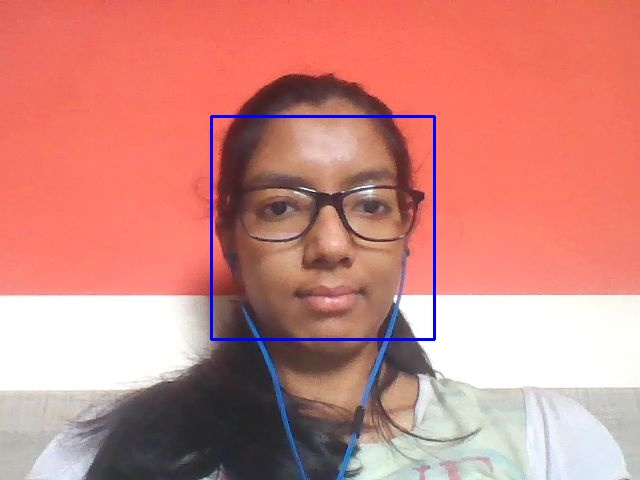

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

#**Eye Detection**

In [ ]:
pip install opencv-python dlib scipy


In [ ]:
import cv2
import dlib
from scipy.spatial import distance

# Define a function to calculate the Eye Aspect Ratio (EAR)
def calculate_ear(eye):
    # Vertical distances
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    # Horizontal distance
    C = distance.euclidean(eye[0], eye[3])
    # EAR formula
    ear = (A + B) / (2.0 * C)
    return ear

# Load the pre-trained models
face_detector = dlib.get_frontal_face_detector()  # Face detector
landmark_predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")  # 68 facial landmarks

def detect_eye_state(image_path):
    # Read the image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_detector(gray)

    for face in faces:
        # Predict facial landmarks
        landmarks = landmark_predictor(gray, face)

        # Extract eye coordinates
        left_eye = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(36, 42)]
        right_eye = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(42, 48)]

        # Calculate EAR for both eyes
        left_ear = calculate_ear(left_eye)
        right_ear = calculate_ear(right_eye)

        # Average EAR
        avg_ear = (left_ear + right_ear) / 2.0

        # Determine if eyes are open or closed
        if avg_ear < 0.25:  # Threshold for closed eyes
            return "Eyes Closed"
        else:
            return "Eyes Open"

    return "No face detected"

# Example usage
image_path = "/content/photo.jpg"
eye_state = detect_eye_state(image_path)
print(eye_state)


Eyes Open


#**Person's Position Detection**

In [ ]:
pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 14.8 MB/s eta 0:00:00


In [ ]:
import cv2
from ultralytics import YOLO

# Load the YOLOv8 model (you can replace 'yolov8s' with other versions like 'yolov8n', 'yolov8m', etc.)
model = YOLO('yolov8s.pt')

def detect_person_position(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Perform object detection
    results = model.predict(img)

    # Extract bounding boxes and labels
    boxes = results[0].boxes  # List of bounding boxes
    for box in boxes:
        if int(box.cls) == 0:  # Class 0 corresponds to 'person' in YOLO models
            # Extract box coordinates and confidence
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            confidence = box.conf.cpu().numpy()

            # Calculate the center of the bounding box
            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2

            # Determine the position based on the center x-coordinate
            frame_width = img.shape[1]
            if center_x < frame_width / 3:
                position = "Left"
            elif center_x > 2 * frame_width / 3:
                position = "Right"
            else:
                position = "Center"

            return position

    return "No person detected"

# Example usage
image_path = "/content/photo.jpg"
position = detect_person_position(image_path)
print("position= ",position)



0: 480x640 1 person, 462.7ms
Speed: 3.9ms preprocess, 462.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
position=  Center
